In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import cv2
import numpy as np

def extract_features(image_path, bins=8):
    img = cv2.imread(image_path) # channels in order BGR
    img = cv2.resize(img, (170, 170))
    features = {}
    
    # Color features (mean, std, median)

    for i, color in enumerate(['blue', 'green', 'red']):
        channel = img[:,:,i]
        
        features[f'{color}_mean'] = np.mean(channel)
        features[f'{color}_std'] = np.std(channel)
        features[f'{color}_median'] = np.median(channel)
        



        # Calculate histogram for each color channel , 
        hist = cv2.calcHist([channel], [0], None, [bins], [0, 256])  
         #bins is using 8 as value which is generally the default
         # None means that no mask are needed, we take all the pixels! 
         #

        # hist = hist / hist.sum()  # Normalize the histogram, so the sum is 1 
        
        # Add histogram bins to features
        for j in range(bins):
            features[f'{color}_hist_{j}'] = hist[j][0]
    
    return features

In [3]:
# 2. Process all images
def process_dataset(root_dir):
    classes = ['Normal_Sperm', 'Abnormal_Sperm', 'Non-Sperm']
    features = []
    labels = []
    
    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        if not os.path.exists(class_dir):
            continue
            
        for img_file in os.listdir(class_dir):
            if img_file.lower().endswith(('.png', '.jpg', '.bmp')):
                img_path = os.path.join(class_dir, img_file)
                try:
                    feats = extract_features(img_path)
                    features.append(feats)
                    labels.append(class_idx)
                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")
    
    features_df = pd.DataFrame(features)
    labels_df = pd.DataFrame(labels, columns=["Labels"])
    
    return features_df, labels_df

In [4]:

print("Processing dataset...")
X, y = process_dataset('data_resized')
print(f"Loaded {len(X)} samples with {len(X.columns)} features")

Processing dataset...
Loaded 3000 samples with 33 features


In [5]:
X

,blue_mean,blue_std,blue_median,blue_hist_0,blue_hist_1,blue_hist_2,blue_hist_3,blue_hist_4,blue_hist_5,blue_hist_6,...,red_std,red_median,red_hist_0,red_hist_1,red_hist_2,red_hist_3,red_hist_4,red_hist_5,red_hist_6,red_hist_7
0,183.713460,7.206447,186.0,0.0,0.0,0.0,1.0,693.0,27648.0,558.0,...,23.211041,200.0,0.0,337.0,263.0,260.0,608.0,2123.0,25309.0,0.0
1,182.213149,5.338925,183.0,0.0,0.0,0.0,0.0,279.0,28360.0,261.0,...,19.888551,197.0,2.0,157.0,275.0,300.0,478.0,2934.0,24749.0,5.0
2,177.159481,5.190762,178.0,0.0,0.0,0.0,0.0,590.0,28228.0,82.0,...,20.313784,195.0,23.0,171.0,303.0,285.0,466.0,2447.0,25205.0,0.0
3,176.252630,5.892446,177.0,0.0,0.0,0.0,7.0,815.0,28061.0,17.0,...,22.986629,194.0,37.0,206.0,347.0,437.0,971.0,6213.0,20669.0,20.0
4,179.263529,5.638385,180.0,0.0,0.0,0.0,0.0,592.0,28205.0,103.0,...,21.265165,193.0,78.0,205.0,238.0,285.0,528.0,6790.0,20776.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,192.897993,8.089506,195.0,0.0,0.0,0.0,0.0,26.0,8324.0,20550.0,...,15.472870,213.0,0.0,0.0,0.0,34.0,694.0,3182.0,24796.0,194.0
2996,182.838374,12.358646,186.0,0.0,0.0,0.0,2.0,1287.0,19002.0,8609.0,...,35.140899,200.0,1.0,313.0,823.0,1402.0,2562.0,6564.0,17083.0,152.0
2997,177.146125,7.898083,179.0,0.0,0.0,0.0,15.0,1513.0,27363.0,9.0,...,18.663659,197.0,0.0,13.0,223.0,518.0,993.0,2804.0,24349.0,0.0
2998,180.540519,10.479318,183.0,0.0,0.0,0.0,321.0,989.0,27458.0,132.0,...,30.764762,196.0,418.0,434.0,244.0,195.0,287.0,3012.0,24310.0,0.0


In [5]:
def plot_distribution_before_after(X_before, X_after, feature_name):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Before scaling
    axes[0].hist(X_before[feature_name], bins=30, color='skyblue', edgecolor='black')
    axes[0].set_title(f'Before Scaling: {feature_name}')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Frequency')

    # After scaling
    axes[1].hist(X_after[feature_name], bins=30, color='salmon', edgecolor='black')
    axes[1].set_title(f'After Scaling: {feature_name}')
    axes[1].set_xlabel('Value')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.savefig('scaling.png', dpi=300, bbox_inches='tight')
    plt.show()

In [6]:
X.dtypes.value_counts()

float32    24
float64     9
Name: count, dtype: int64

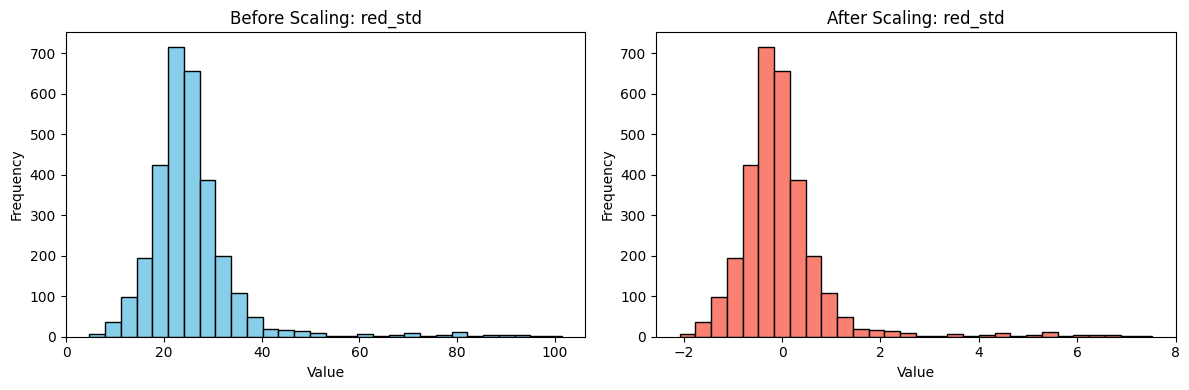

In [7]:
X.columns = X.columns.astype(str)

X_numeric = X.select_dtypes(include=['number'])

# Scale the numeric features
scaler = StandardScaler()
X_after_array = scaler.fit_transform(X_numeric)

# Convert scaled data back to DataFrame
X_after = pd.DataFrame(X_after_array, columns=X_numeric.columns)

feature_name = X_numeric.columns[23]  # or any index
plot_distribution_before_after(X_numeric, X_after, feature_name)

In [8]:
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

X_train, X_test, y_train, y_test = train_test_split(X_after, y.values.ravel(), test_size=0.2, stratify=y, random_state=42)


In [ ]:


# 6. Advanced Classifiers with Hyperparameter Tuning

## Random Forest
print("\n=== Random Forest (Optimized) ===")
rf_params = {
    # Previously we had : 
    'n_estimators': [100, 200, 300],  
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    
    # New Additions 
    'criterion': ['gini'],    
    'max_features': ['sqrt', 'log2', None, 0.5, 0.8]  # for 33 features, sqrt of it would be around 5 or 6 selected features
                                                      # log2 would be around  5 features 
                                                      #None would select all the 33 features
                                                      #0.5 would select 50% and 0.3 would select 30% of the features
}

rf = GridSearchCV(RandomForestClassifier(random_state=42),  rf_params, cv=5, n_jobs=-1)
rf.fit(X_train, y_train)
print(f"Best params: {rf.best_params_}")
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))




=== Random Forest (Optimized) ===


Best params: {'criterion': 'gini', 'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.64      0.59      0.61       204
           1       0.59      0.63      0.61       201
           2       0.83      0.84      0.84       195

    accuracy                           0.69       600
   macro avg       0.69      0.69      0.69       600
weighted avg       0.69      0.69      0.68       600



In [10]:
rf

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [10, 20, 30],
                         'max_features': ['sqrt', 'log2', None, 0.5, 0.8],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]})

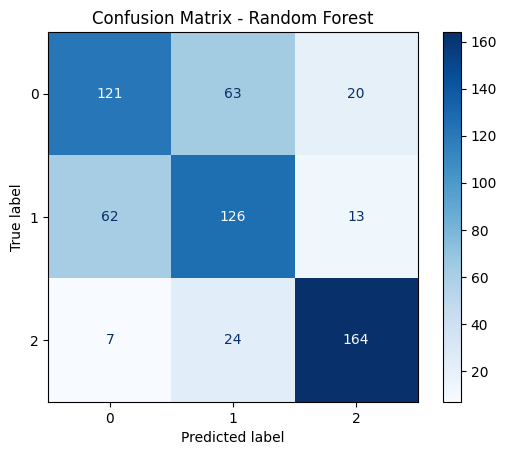

In [11]:
# 🟦 Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap='Blues')  # Optional: better color
plt.title("Confusion Matrix - Random Forest")
plt.savefig('confusion_matrix_rf.png', dpi=300, bbox_inches='tight')  # Save the figure
plt.show() 


In [11]:
my_results_RF = pd.DataFrame(rf.cv_results_)

In [12]:
my_results_RF

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.355261,0.246573,0.033776,0.017173,10,1,2,100,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.695833,0.625000,0.679167,0.691667,0.697917,0.677917,0.027246,48
1,2.293705,0.253983,0.064900,0.031572,10,1,2,200,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.691667,0.637500,0.675000,0.700000,0.702083,0.681250,0.023863,40
2,3.487629,0.318448,0.065540,0.006942,10,1,2,300,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.697917,0.629167,0.668750,0.702083,0.697917,0.679167,0.027701,44
3,1.022219,0.084296,0.029289,0.011612,10,1,5,100,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.697917,0.650000,0.689583,0.702083,0.706250,0.689167,0.020344,17
4,1.982538,0.113149,0.041636,0.004080,10,1,5,200,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.691667,0.641667,0.685417,0.710417,0.697917,0.685417,0.023385,31
5,2.960188,0.214345,0.061850,0.006651,10,1,5,300,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.691667,0.639583,0.672917,0.708333,0.683333,0.679167,0.022936,44
6,0.935516,0.048145,0.022692,0.002729,10,1,10,100,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.679167,0.629167,0.685417,0.700000,0.693750,0.677500,0.025187,49
7,1.865070,0.080155,0.041198,0.007433,10,1,10,200,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.681250,0.631250,0.681250,0.695833,0.706250,0.679167,0.025753,44
8,3.026645,0.235343,0.068170,0.007233,10,1,10,300,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.681250,0.627083,0.679167,0.695833,0.702083,0.677083,0.026451,51
9,0.883971,0.010091,0.020312,0.000292,10,2,2,100,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",0.691667,0.643750,0.685417,0.704167,0.689583,0.682917,0.020556,39


In [13]:
my_results_RF.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split',
       'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [14]:
columns_to_show = [
  'param_n_estimators',
    'param_max_depth',
    'param_min_samples_leaf',
    
    'param_min_samples_split',
    'mean_test_score',
    'rank_test_score'
 ]

In [15]:
sorted_results = my_results_RF[columns_to_show].sort_values(by='rank_test_score')

In [16]:
sorted_results

,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_score,rank_test_score
46,200,30,2,2,0.696667,1
45,100,30,2,2,0.694583,2
47,300,30,2,2,0.693333,3
23,300,20,1,5,0.693333,3
19,200,20,1,2,0.693333,5
21,100,20,1,5,0.692083,6
32,300,20,2,5,0.691667,7
39,100,30,1,5,0.691667,8
27,100,20,2,2,0.691667,8
26,300,20,1,10,0.691250,10


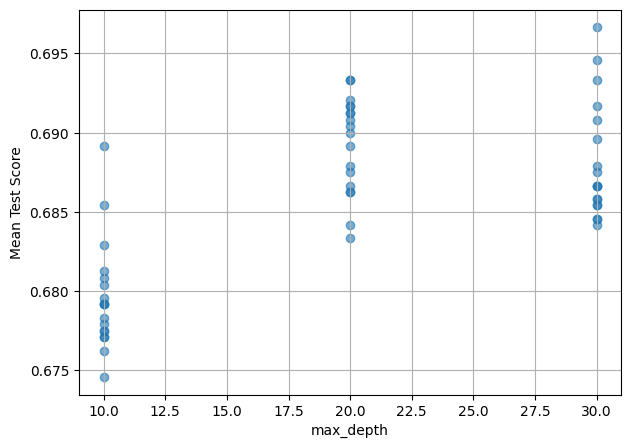

In [ ]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is `df`
plt.figure(figsize=(8, 5))
plt.scatter(sorted_results['param_max_depth'], sorted_results['mean_test_score'], alpha=0.6)
 
plt.xlabel("max_depth")
plt.ylabel("Mean Test Score")
plt.grid(True)
plt.savefig('max_depth_vs_test_score.png', dpi=300, bbox_inches='tight')

plt.show()

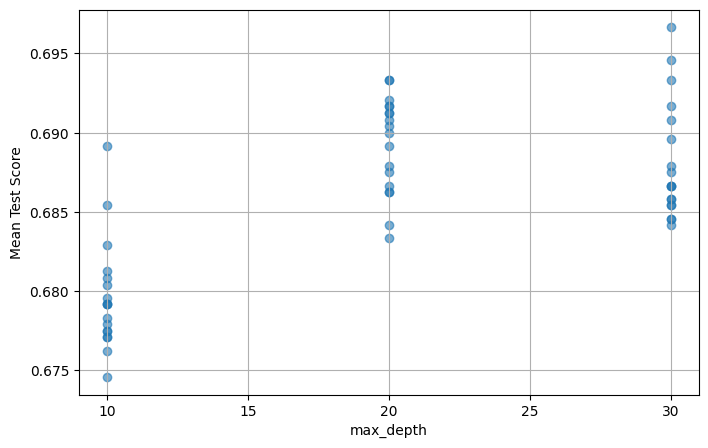

In [19]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is `sorted_results`
plt.figure(figsize=(8, 5))
plt.scatter(sorted_results['param_max_depth'], sorted_results['mean_test_score'], alpha=0.6)

plt.xlabel("max_depth")
plt.ylabel("Mean Test Score")
plt.grid(True)

# Set x-axis ticks to go by 5 (e.g., 10, 15, 20, ..., max value in your data)
x_min = sorted_results['param_max_depth'].min()
x_max = sorted_results['param_max_depth'].max()
plt.xticks(range(x_min, x_max + 1, 5))  # Step of 5

plt.savefig('max_depth_vs_test_score2.png', dpi=300, bbox_inches='tight')
plt.show()


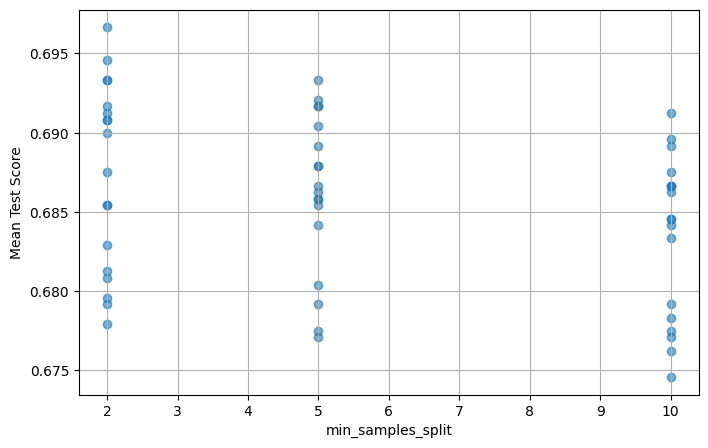

In [21]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is `df`
plt.figure(figsize=(8, 5))
plt.scatter(sorted_results['param_min_samples_split'], sorted_results['mean_test_score'], alpha=0.6)
 
plt.xlabel("min_samples_split")
plt.ylabel("Mean Test Score")
plt.grid(True)
plt.savefig('min_samples_split_vs_test_scoreNEW.png', dpi=300, bbox_inches='tight')

plt.show()

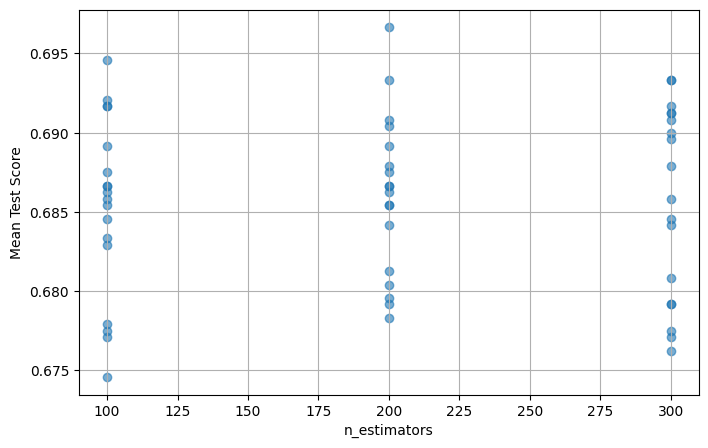

In [25]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is `df`
plt.figure(figsize=(8, 5))
plt.scatter(sorted_results['param_n_estimators'], sorted_results['mean_test_score'], alpha=0.6)
 
plt.xlabel("n_estimators")
plt.ylabel("Mean Test Score")
plt.grid(True)
plt.savefig('n_estimators_vs_test_scoreNEW.png', dpi=300, bbox_inches='tight')

plt.show()

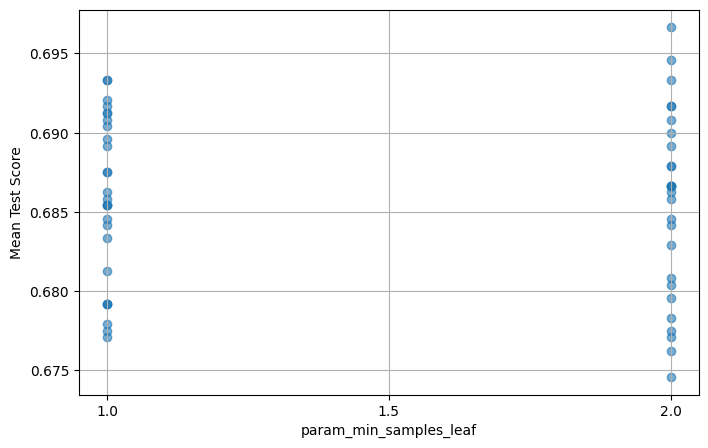

In [27]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is `sorted_results`
plt.figure(figsize=(8, 5))
plt.scatter(sorted_results['param_min_samples_leaf'], sorted_results['mean_test_score'], alpha=0.6)

plt.xlabel("param_min_samples_leaf")
plt.ylabel("Mean Test Score")
plt.grid(True)

# Set x-axis ticks manually to 1, 1.5, and 2
plt.xticks([1, 1.5, 2])

plt.savefig('param_min_samples_leaf_vs_test_scoreNEW.png', dpi=300, bbox_inches='tight')
plt.show()


In [1]:


import cv2
import matplotlib.pyplot as plt

def calc_hist(sample_image, bins=8, save_path = None ):
     
    testing = cv2.imread(sample_image)
   
    if testing is None:
        print("error with the image")
        return
    
    plt.figure(figsize=(10, 5))
    
    for i, color in enumerate(['blue', 'green', 'red']):
        channel = testing[:,:,i] 
        hist = cv2.calcHist([channel], [0], None, [bins], [0, 256])  # Fixed parameters
        #hist = hist / hist.sum()  # Normalize histogram
        
        plt.plot(hist, color=color, label=color)  # Plot with color labels
    
    plt.title("Color Channel Histograms (No normalized)")
    plt.xlabel("Intensity of the channels")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches = 'tight')
        print(f'The color hist of your sample image is stored in: {save_path}')
    plt.show()
        



The color hist of your sample image is stored in: Sperm_histogram


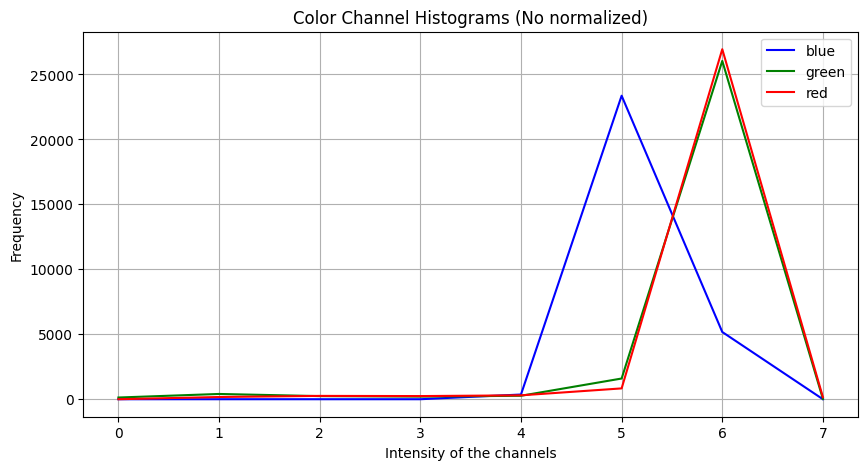

In [2]:
calc_hist('Normal_Sperm (1).bmp', save_path='Sperm_histogram')

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calc_hist_improved(sample_image, bins=8, save_path=None):
    img = cv2.imread(sample_image)
    if img is None:
        print("Error: could not load image.")
        return

    # we’ll plot normalized counts so channels are directly comparable
    plt.figure(figsize=(10, 5))

    channel_names = ['Blue', 'Green', 'Red']
    for i, name in enumerate(channel_names):
        channel = img[:, :, i]
        hist = cv2.calcHist([channel], [0], None, [bins], [0, 256])
        hist = hist.flatten()
        hist = hist / hist.sum()                # normalize to [0–1]
        
        # plot default color cycle, label with channel name
        plt.plot(hist, label=f"{name} channel", linewidth=2)
        plt.fill_between(np.arange(bins), hist, alpha=0.2)

    # label each bin by its intensity range
    bin_edges = np.linspace(0, 256, bins+1, dtype=int)
    tick_labels = [f"{bin_edges[j]}–{bin_edges[j+1]-1}" for j in range(bins)]
    plt.xticks(np.arange(bins), tick_labels, rotation=45)

    plt.title("Normalized Color-Channel Histograms", fontsize=14)
    plt.xlabel("Intensity Range", fontsize=12)
    plt.ylabel("Relative Frequency", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved improved histogram to {save_path}")

    plt.show()
